In [1]:
# import libs
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,\
                                    Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

In [2]:
# get data
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
# normalise data
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
# convert to tensor data
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [3]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [4]:
#  The tf.data.AUTOTUNE parameter dynamically determines the appropriate number of elements 
#  to prefetch based on available system resources

train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [5]:
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

In [6]:
# encoder
encoder_inputs = Input(shape=(28,28,1))
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
# mean and log var values are small  - map using log
# 0 to 1 mapped to -inf to 0 using log
mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM,)(x)
z = Sampling()([mean,log_var])
encoder_model = Model(encoder_inputs,[z,mean,log_var], name='encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [7]:
latent_inputs = Input(shape=(LATENT_DIM,))
x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
# to restrict output value to 0 to 1 - signoid has been used
decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [8]:
def custom_loss(y_true,y_pred,mean,log_var):
    # perf binary cross entropy on images (arr) - hence reduce mean is used
    # data is in shape (batch_num,28,28,1) -- axis (0,1,2,3) -- axis to compute loss = 1,2
    loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))
    loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
    # shape of latent = (batch,2)
    return loss_rec+tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))

In [9]:
vae_input = Input(shape=(28,28,1), name="vae_input")
z,_,_ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


In [10]:
OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 20

In [11]:
# train vae
@tf.function
def train_vae(x_batch):
    
    with tf.GradientTape() as recorder:
        z,mean,log_var = encoder_model(x_batch)
        y_pred = decoder_model(z)
        y_true = x_batch
        loss = custom_loss(y_true,y_pred, mean, log_var)
    
    # compute gradients
    partial_derivatives = recorder.gradient(loss,vae.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
    return loss

In [12]:
for epoch in range(1,EPOCHS+1):
    for step, x_batch in enumerate(train_dataset):
        loss = train_vae(x_batch)
    print(f'train loss @ epoch : {epoch}: ', loss)

train loss @ epoch : 1:  tf.Tensor(196.02061, shape=(), dtype=float32)
train loss @ epoch : 2:  tf.Tensor(170.50104, shape=(), dtype=float32)
train loss @ epoch : 3:  tf.Tensor(168.88124, shape=(), dtype=float32)
train loss @ epoch : 4:  tf.Tensor(166.90419, shape=(), dtype=float32)
train loss @ epoch : 5:  tf.Tensor(155.38838, shape=(), dtype=float32)
train loss @ epoch : 6:  tf.Tensor(161.51917, shape=(), dtype=float32)
train loss @ epoch : 7:  tf.Tensor(162.6637, shape=(), dtype=float32)
train loss @ epoch : 8:  tf.Tensor(152.40683, shape=(), dtype=float32)
train loss @ epoch : 9:  tf.Tensor(158.04591, shape=(), dtype=float32)
train loss @ epoch : 10:  tf.Tensor(150.37903, shape=(), dtype=float32)
train loss @ epoch : 11:  tf.Tensor(152.47205, shape=(), dtype=float32)
train loss @ epoch : 12:  tf.Tensor(156.0857, shape=(), dtype=float32)
train loss @ epoch : 13:  tf.Tensor(156.86865, shape=(), dtype=float32)
train loss @ epoch : 14:  tf.Tensor(158.20871, shape=(), dtype=float32)
tra

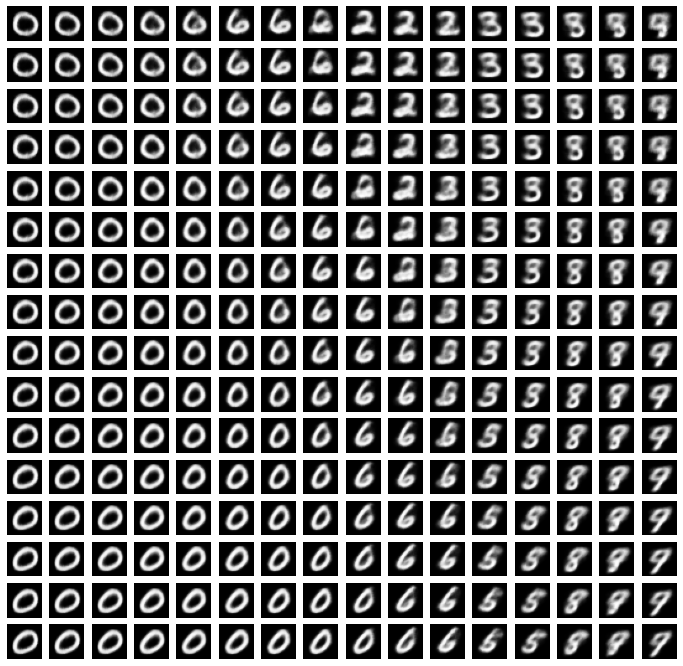

In [16]:
# generate images using decoder block

scale=1
n=16
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)
plt.figure(figsize=(12,12))
k=0
for i in grid_x:
    for j in grid_y:
        ax=plt.subplot(n,n,k+1)

        inp=tf.constant([[i,j]])
        out=vae.layers[2].predict(inp)[0][...,0]
        plt.imshow(out,cmap="Greys_r")
        plt.axis('off')
        k+=1